In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset
There are lots of MRI datasets both for 2D and 3D images....
* [https://www.kaggle.com/datasets/awsaf49/brats2020-training-data](http://)
* [https://www.kaggle.com/datasets/awsaf49/brain-tumor](http://)
* [https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=5309188](http://)
* [https://osf.io/axz5r/](http://)
* [https://www.kaggle.com/datasets/srinivasbece/brain-tumor-databasebtd600](http://)
* [https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection](http://)
* [https://figshare.com/articles/dataset/brain_tumor_dataset/1512427](http://)

# First Attempt-01 on 2D MRI dataset for multi-classification problem

## Create dataset class

In [3]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [4]:
class CustomImageDataset(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        
        # Apply the Albumentations transform
        image = np.array(image)  # Convert to numpy array
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, label

In [5]:
class MRI2D_Dataset(Dataset):
    def __init__(self,PATH,transform=None):
        self.transform = transform
        images = []
        labels = []
        i = 0
        for dir,sub_dir,_ in os.walk(PATH):
            if dir!=PATH:
                for sub in sub_dir:
                    new_path = os.path.join(dir,sub)
                    if sub == 'pituitary':
                        i = 3
                    if sub == 'glioma':
                        i = 1
                    if sub == 'meningioma':
                        i = 2
                    if sub == 'notumor':
                        i = 0
                    for _,_,files in os.walk(new_path):
                        for file in files:
                            img_path = os.path.join(new_path,file)
                            img = cv2.imread(img_path)
                            img = self.data_preprocessing(img)
                            img = img.reshape(img.shape[-1],img.shape[0],img.shape[1])
                            images.append(img)
                            labels.append(i)
        self.images = np.array(images)
        self.labels = np.array(labels).astype(np.int64)
    def __getitem__(self,index):
        img = self.images[index]
        if self.transform:
            img = self.transform(img) #3,128,128
        #img = img.reshape(img.shape[-1],img.shape[0],img.shape[1])
        label = self.labels[index]
        return img,label
    def __len__(self):
        return self.images.shape[0]
    def data_preprocessing(self,img):
        resized = cv2.resize(img,(128,128),interpolation = cv2.INTER_LINEAR)
        resized = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
        resized = resized-resized.min()
        resized = (resized/resized.max()).astype(dtype=np.float32)
        return resized

In [6]:
data_transforms = A.Compose([
    A.Resize(128, 128),
    #A.CLAHE(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [7]:
train_dataset = CustomImageDataset(train_path, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

val_dataset = CustomImageDataset(test_path, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)

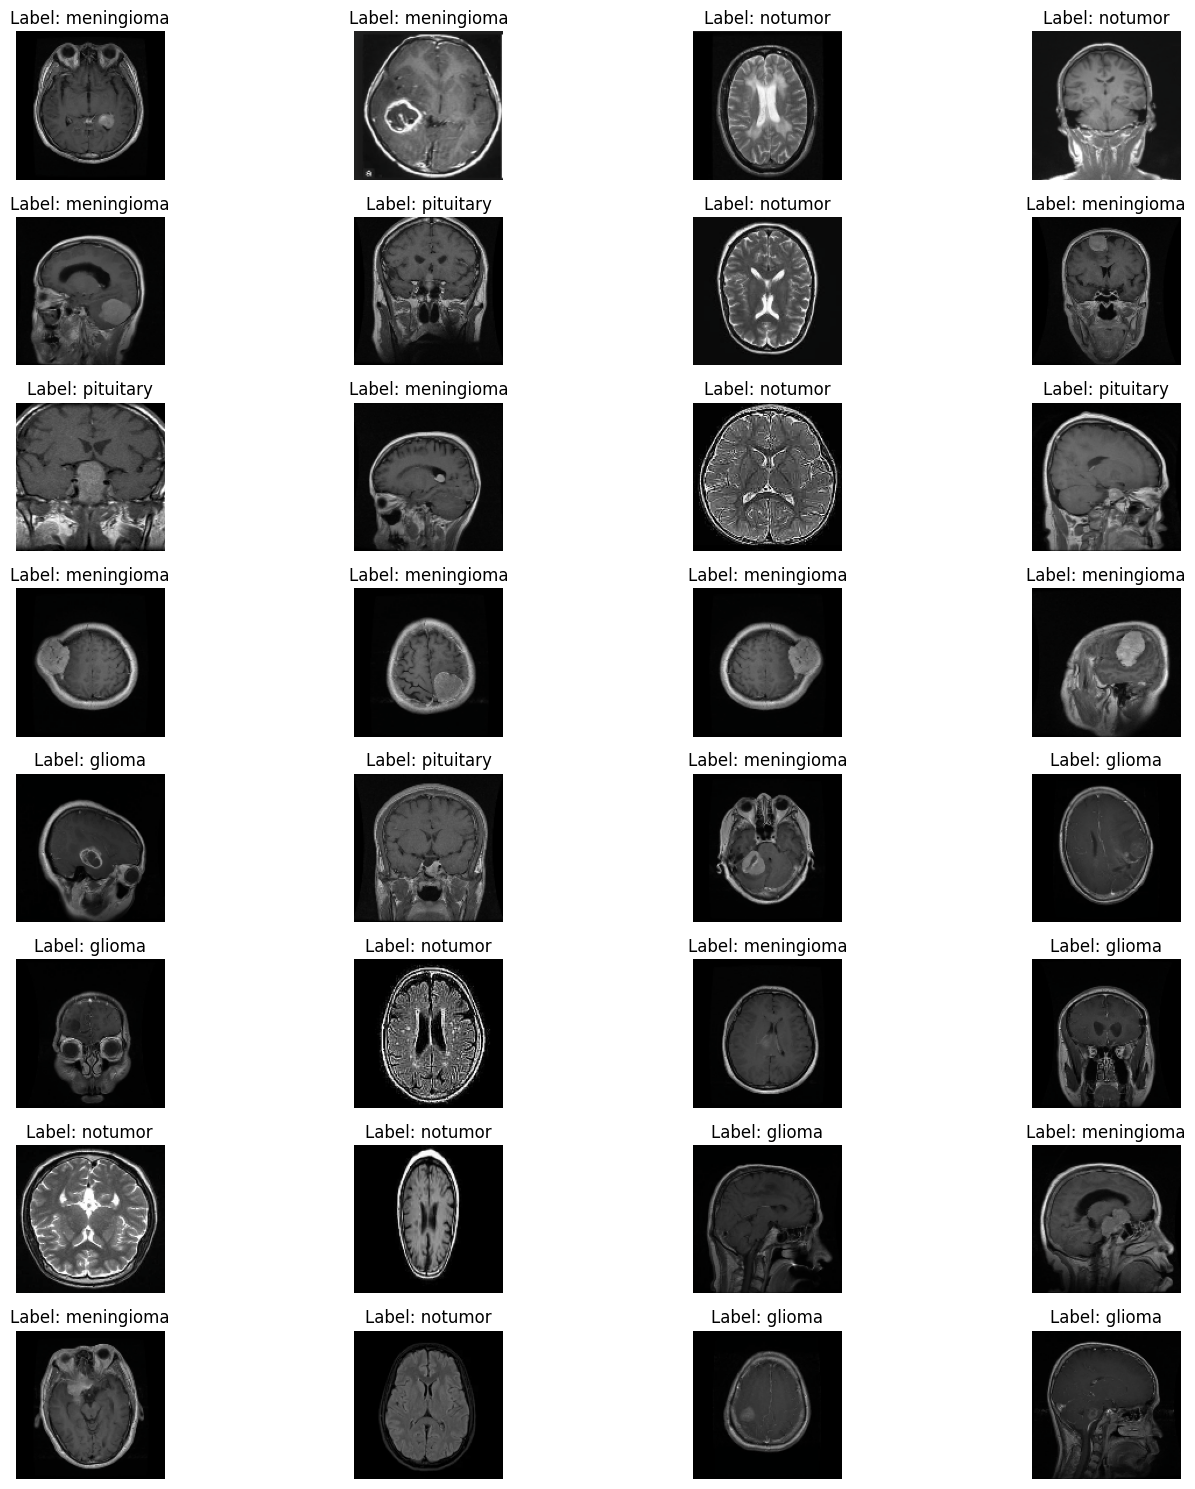

In [8]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Constant related to dataset

In [ ]:
PATH = '/kaggle/input/brain-tumor-mri-dataset'

In [ ]:
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
dataset = MRI2D_Dataset(PATH)  
BATCH_SIZE = 32
TRAIN_SIZE = int(0.8*len(dataset))
TEST_SIZE = len(dataset)-TRAIN_SIZE

### Load and split data

In [ ]:
train_data,test_data = random_split(dataset,[TRAIN_SIZE,TEST_SIZE],generator=torch.manual_seed(42))
trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Proposed Model

In [ ]:

class Conv_Block(nn.Module):
    def __init__(self,in_channels=3):
        super(Conv_Block,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=16,kernel_size=5,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(in_channels=16,out_channels=128,kernel_size=3,stride=3)
        )
        self.block2a = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=32,kernel_size=1,stride=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
        )
        self.block2b = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.Tanh(),
        )
        self.block2c = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.avgpool = nn.AvgPool2d(kernel_size=3,stride=1,padding=1)
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=1)
        )
    def forward(self,x):
        data = x
        out1 = self.block1(data)
        out2a = self.block2a(out1)
        
        out2b = self.block2b(out1)
        
        out2c = self.block2c(out1)
        
        out2 = torch.cat([out2a,out2b,out2c],dim=1)
        
        out2 = self.avgpool(out2)
        
        data = out1 + out2
        out3 = self.block3(data)
        
        return out3

In [ ]:
class Embedding(nn.Module):
    def __init__(self,in_channels,patch_size,embedding_dim):
        super(Embedding,self).__init__()
        self.patch_size=patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)
    def forward(self,x):
        img_res = x.shape[-1]
        assert(img_res%self.patch_size == 0),"Input image size must be divisible by patch"
        
        x_patched = self.patcher(x)
        
        x_patched = x_patched.view(x_patched.shape[0],x_patched.shape[1],-1).permute(0,2,1)
        #x_patched = self.norm(x_patched)
        return x_patched

In [ ]:
class MHSA(nn.Module):
    def __init__(self,embed_size=128,head=8,dropout=0.2):
        super(MHSA,self).__init__()
        self.embed_size = embed_size
        self.heads = head
        self.head_dim = embed_size//head
        
        assert (self.head_dim*self.heads == embed_size), "Embed size needs to be div by heads"
        self.W_q = nn.Linear(self.head_dim,self.head_dim,bias=False)
        self.W_k = nn.Linear(self.head_dim,self.head_dim,bias=False)
        self.W_v = nn.Linear(self.head_dim,self.head_dim,bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(self.head_dim*self.heads,self.embed_size,bias=False)
        
    def forward(self,V,K,Q):
        N = Q.shape[0]
        
        q_len, v_len, k_len = Q.shape[1], V.shape[1], K.shape[1]
        
        Q = Q.view(N,q_len,self.heads,self.head_dim)
        K = K.view(N,k_len,self.heads,self.head_dim)
        V = V.view(N,v_len,self.heads,self.head_dim)
        queries = self.W_q(Q)
        keys = self.W_k(K)
        values = self.W_v(V)
        #print(queries.shape)
        #queries = self.W_q(Q).view(N,q_len,self.heads,self.head_dim)
        #keys = self.W_k(K).view(N,k_len,self.heads,self.head_dim)
        #values = self.W_v(V).view(N,v_len,self.heads,self.head_dim)
        
        # (N,q_len,heads,head_dim) x (N,k_len,heads,head_dim) -> (N,heads,q_len,k_len)
        score = torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
        scaled = score/(self.head_dim**0.5)
        scores = torch.softmax(scaled,dim=3)
        self.attention_score = scores
        # (N,heads,q_len,k_len) x (N,v_len,heads,head_dim) -> (N,heads,q_len,k_len)
        attn = torch.einsum("nhql,nlhd->nqhd",[self.attention_score,values]).reshape(N,q_len,self.heads*self.head_dim)
        out = self.fc_out(attn)
        
        return out

In [ ]:
class Attention_Block(nn.Module):
    def __init__(self,embed_size,heads):
        super(Attention_Block,self).__init__()
        #self.conv = nn.Conv2d(in_channels=3,out_channels=embed_size,kernel_size=4,stride=4)
        self.attn1 = MHSA(embed_size,heads)
        self.attn2 = MHSA(embed_size,heads)
        self.relu = nn.GELU()
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
    def forward(self,x): #X->N,C,H,W
        
        
        #N,C,H,W = x.shape
        #x = x.reshape(N,H*W,C)
    
        x = x + self.attn1(x,x,x)
        x = self.norm1(x)
        x = self.relu(x)
        x = x + self.attn2(x,x,x)
        x = self.norm2(x)
        #x = x.view(N,C,H,W)
        
        return x

In [ ]:
class CAN(nn.Module):
    def __init__(self,img_size=128,in_channels=3,out_classes=4,patch_size=4,embed_dim=64):
        super(CAN,self).__init__()
        self.num_patches = (img_size*img_size)//(patch_size**2) # 256
        self.conv1 = Conv_Block(in_channels)
        self.patch_embedding = Embedding(in_channels,patch_size,embed_dim)
        self.embed_dropout = nn.Dropout(0.1)
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embed_dim),requires_grad=True)
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embed_dim),requires_grad=True)
        self.attn_block1 = Attention_Block(embed_dim,4)
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=7,stride=7,padding=0),
            nn.Tanh(),
            nn.AvgPool1d(kernel_size=3,stride=3,padding=1)
        )
        self.mlpForConv = nn.Sequential(
            nn.Linear(3136,1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256,4)
        )
        self.mlpForConvWithAttn = nn.Sequential(
            nn.Linear(64*49,2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,4)
        )
        self.dropout = nn.Dropout(0.4)

        self.linear = nn.Linear(8,4)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x): # 16,3,128,128
        N,C,H,W = x.shape
        conv_out = self.conv1(x)#16,64,7,7
        
        #batch_size = x.shape[0]
        class_token = self.class_embedding.expand(N,-1,-1)
        attn_out1 = self.patch_embedding(x) # 16,256,64
        attn_out1 = torch.cat([class_token,attn_out1],dim=1)
        attn_out1 = self.position_embedding + attn_out1
        attn_out1 = self.embed_dropout(attn_out1)
        
        #attn_out1 = x
        attn_out1 = self.attn_block1(attn_out1)
        attn_out1 = attn_out1.transpose(1,2)
        
        attn_conv = self.conv2(attn_out1)
        
        attn_conv = attn_conv.view(attn_conv.shape[0],attn_conv.shape[1],-1) # 16, 64,49
        
        #attn_out2 = self.attn_block2(attn_out1)
        #attn_out = attn_out1 + attn_out2
        #attn_conv = self.conv2(attn_out)#16,65,49
        
        conv_out = conv_out.reshape(conv_out.shape[0],conv_out.shape[1],-1)#16,64,49
        #convWithAttn = torch.cat([attn_conv,conv_out],dim=1) #16,128,49
        convWithAttn = attn_conv
        
        # MLP for Convolution features
        conv_out = self.dropout(conv_out)
        conv_out = conv_out.view(conv_out.size(0),-1)
        conv_out = self.mlpForConv(conv_out)
        #conv_out = self.softmax(conv_out)
        
        
        # MLP for Convolution+Attention features
        convWithAttn = self.dropout(convWithAttn)
        convWithAttn = convWithAttn.view(convWithAttn.size(0),-1)
        convWithAttn = self.mlpForConvWithAttn(convWithAttn)
        #convWithAttn = self.softmax(convWithAttn)
        
        x = torch.cat([convWithAttn,conv_out],dim=1)
        x = self.linear(x)
        
        return x

In [7]:
def plot_graph(loss, acc, test_loss, test_acc):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    ax[0].plot(loss, c='r', label='train_loss')
    ax[0].plot(test_loss, c='b',linestyle='--', label='test_loss')
    ax[0].set_xlabel('epoch')  
    ax[0].set_ylabel('loss')   
    ax[0].legend()

    ax[1].plot(acc, c='r', label='train_acc')
    ax[1].plot(test_acc, c='b',linestyle='--', label='test_acc')
    ax[1].set_xlabel('epoch')  
    ax[1].set_ylabel('acc')    
    ax[1].legend()

    fig.tight_layout()
    #plt.show()
    plt.savefig('/kaggle/working/loss.pdf',dpi=600)

In [ ]:
def test_model(model,testLoader,criterion):
    losses = []
    accs = []
    n_sample = 0
    n_correct = 0
    model.eval()
    for x_test,y_test in testLoader:
        with torch.inference_mode():
            out = model(x_test.to(device))
            loss = criterion(out.squeeze(),y_test.to(device))
            n_correct += (torch.argmax(out,dim=1)==y_test.to(device)).sum()
            #print(f"accuracy in each batch:{n_sample/BATCH_SIZE}")
            n_sample += x_test.shape[0]
            test_acc = n_correct/n_sample
            losses.append(loss.cpu().detach().numpy())
            accs.append(test_acc.cpu().detach().numpy())
    return np.mean(losses),np.mean(accs),n_correct/n_sample

In [ ]:
model = CAN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model.parameters(),lr=0.00138,weight_decay=0.0002)

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
scheduler = lr_scheduler.StepLR(optimizer,step_size=50, gamma=0.1)

In [ ]:
def train_model(model,trainLoader,optimizer,criterion):
    losses = []
    accs = []
    n_sample = 0
    n_correct = 0
    model.train()
    for x_train,label in trainLoader:
        # Training
        out = model(x_train.to(device))
        loss = criterion(out,label.to(device))
        n_correct += (torch.argmax(out,dim=1)==label.to(device)).sum()
        #print(label.shape)
        #n_correct += find_correct_prediction(outputs.clone(),label)
        #print(f"accuracy in each batch:{n_sample/BATCH_SIZE}")
        n_sample += x_train.shape[0]
        acc = n_correct/n_sample
        losses.append(loss.cpu().detach().numpy())
        accs.append(acc.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #scheduler.step()
    return np.mean(losses),np.mean(accs),n_correct/n_sample

In [ ]:
EPOCHS = 100

In [ ]:
import copy
best_acc = 0
best_model = None

In [ ]:
train_losses = []
test_losses = []
train_accuries = []
test_accuries = []
start_time = time.time()
for epoch in range(EPOCHS):
    epoch_time = time.time()
    loss,accs,acc = train_model(model,train_loader,optimizer,criterion)
    test_loss,t_accs,test_acc = test_model(model,val_loader,criterion)
    #scheduler.step()
    epoch_total = time.time()- epoch_time
    train_losses.append(loss)
    test_losses.append(test_loss)
    train_accuries.append(accs)
    test_accuries.append(t_accs)
    if test_acc>best_acc:
        best_acc = test_acc.clone()
        best_model = copy.deepcopy(model)
    print(f'epoch:{epoch}|loss:{loss}|acc:{acc}|test_loss:{test_loss}|test_acc:{test_acc}|time:{epoch_total:.2f} sec')
    
total_time = time.time() - start_time
print(f'Total time:{total_time:.2f} sec')

In [ ]:
plot_graph(train_losses,train_accuries,test_losses,test_accuries)

In [ ]:
best_acc

In [ ]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

In [ ]:
torch.save(best_model.state_dict(),'/kaggle/working/CAN-Adam-1e-3-batch64-multiclass-best-model100acc9802.pth')

In [8]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
y_true = []
predict = []
for X,y in val_loader:
    y_pred = best_model(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())

In [ ]:
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/conf.pdf',dpi=600)

### Plot ROC curve

In [9]:
import itertools
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import roc_auc_score
import scipy
from scipy import interp

In [ ]:
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/roc.pdf',dpi=600)

In [ ]:
plot_ROC(y_true,predict,[0,1,2,3])

### Plot Precision Recall

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall Curve")

    #plt.show()
    plt.savefig('/kaggle/working/recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

In [ ]:
plot_PrecRec(y_true,predict,[0,1,2,3])

### Metrices

In [11]:
from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(y_true,predict)
print(cr)

In [ ]:
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')

In [ ]:
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")

In [ ]:
s = np.array(specificities).mean()

In [ ]:
s

In [ ]:
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

## Visualize Kernel and Attention Score

In [ ]:
model = best_model

In [ ]:
img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0016.jpg')
resized = cv2.resize(img,(128,128),interpolation = cv2.INTER_LINEAR)
resized = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
resized = resized-resized.min()
img = (resized/resized.max()).astype(dtype=np.float32)

In [ ]:
plt.matshow(img)

In [ ]:
img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
img = torch.from_numpy(img).to(device)

In [ ]:
layer0 = model.conv1.block1[0]
layer0_out = layer0(img)

In [ ]:
layer0 = layer0.weight.cpu().detach().numpy()

In [ ]:
fig, ax = plt.subplots(2,8,figsize=(20,5*2))
ax = ax.reshape(-1)
for i,img in enumerate(layer0):
    img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = (img/img.max())*255.0
    ax[i].matshow(img)
    ax[i].axis('off')
plt.show()

In [ ]:
feature = layer0_out.cpu().detach().numpy()

In [ ]:
fig, ax = plt.subplots(2,8,figsize=(20,5*2))
ax = ax.reshape(-1)
for i,img in enumerate(feature):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = img/img.max()*255.0
    ax[i].matshow(img)
    ax[i].axis('off')
plt.savefig('/kaggle/working/layer0feature.pdf',dpi=600)
plt.show()

In [ ]:
layer1_out = model.conv1.block1[4](layer0_out)

In [ ]:
featue1 = layer1_out.cpu().detach().numpy()

In [ ]:
fig, ax = plt.subplots(8,16,figsize=(20,5*8))
ax = ax.reshape(-1)
for i,img in enumerate(featue1):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = img/img.max()*255.0
    ax[i].matshow(img)
    ax[i].axis('off')
plt.savefig('/kaggle/working/layer1feature.pdf',dpi=600)
plt.show()

In [ ]:
layer2a_out = model.conv1.block2a[0](layer1_out)

In [ ]:
feature2 = layer2a_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature2):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(4,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
layer2b_out = model.conv1.block2b[0](layer1_out)

In [ ]:
feature3 = layer2b_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature3):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(8,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
layer2b3_out = model.conv1.block2b[3](layer2b_out)

In [ ]:
feature3 = layer2b3_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature3):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(8,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
layer2c0_out = model.conv1.block2c[0](layer1_out)

In [ ]:
feature3 = layer2c0_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature3):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(4,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
layer2c3_out = model.conv1.block2c[3](layer2c0_out)

In [ ]:
feature3 = layer2c3_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature3):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(4,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
x = torch.cat([layer2a_out,layer2b3_out,layer2c3_out],dim=0)

In [ ]:
input_block3 = layer1_out + x

In [ ]:
layer3_out = model.conv1.block3[0](input_block3)

In [ ]:
feature3 = layer3_out.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10,4))
for i,img in enumerate(feature3):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    plt.subplot(8,8,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Attention

In [ ]:
img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0016.jpg')
resized = cv2.resize(img,(128,128),interpolation = cv2.INTER_LINEAR)
resized = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
resized = resized-resized.min()
img = (resized/resized.max()).astype(dtype=np.float32)

In [ ]:
img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
img = torch.from_numpy(img).to(device)

In [ ]:
patch_img = model.patch_embedding(img)

In [ ]:
feature = patch_img.cpu().detach().numpy()

In [ ]:
fig, ax = plt.subplots(8,8,figsize=(20,5*8))
ax = ax.reshape(-1)
for i,img in enumerate(feature):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = img/img.max()*255.0
    ax[i].matshow(img)
    ax[i].axis('off')
plt.show()

In [ ]:
attn1 = model.attn_block1.attn1
x = patch_img.reshape(patch_img.shape[0],-1).transpose(0,1)
x = x.unsqueeze(0)
out = attn1(x,x,x)
attn_score = attn1.attention_score
A = torch.mean(attn_score,dim=1)
A = A[0].cpu().detach().numpy()
A = (A/A.max())*255

In [ ]:
plt.imshow(A)
plt.axis('off')
plt.savefig('/kaggle/working/attnScore.pdf',dpi=600)

In [ ]:
x = out

In [ ]:
out = out.squeeze().transpose(0,1)

In [ ]:
feature = out.cpu().detach().numpy()

In [ ]:
feature.shape

In [ ]:
fig, ax = plt.subplots(8,8,figsize=(20,5*8))
ax = ax.reshape(-1)
for i,img in enumerate(feature):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = img/img.max()*255.0
    ax[i].matshow(img.reshape(32,32))
    ax[i].axis('off')
plt.savefig('/kaggle/working/attn1feature.pdf',dpi=600)
plt.show()

In [ ]:
attn2 = model.attn_block1.attn2
out = attn2(x,x,x)
attn2_score = attn2.attention_score
A2 = torch.mean(attn2_score,dim=1).cpu().detach().numpy()

In [ ]:
plt.imshow(A2[0])
plt.axis('off')
plt.savefig('/kaggle/working/attnScore2.pdf',dpi=600)

In [ ]:
x = out
out = out.squeeze().transpose(0,1)
feature = out.cpu().detach().numpy()

In [ ]:
fig, ax = plt.subplots(8,8,figsize=(20,5*8))
ax = ax.reshape(-1)
for i,img in enumerate(feature):
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    img = img/img.max()*255.0
    ax[i].matshow(img.reshape(32,32))
    ax[i].axis('off')
plt.savefig('/kaggle/working/attnfeature2.pdf',dpi=600)
plt.show()

## Explanations using Grad-CAM

In [ ]:
img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0022.jpg')
resized = cv2.resize(img,(128,128),interpolation = cv2.INTER_LINEAR)
resized = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
resized = resized-resized.min()
img = (resized/resized.max()).astype(dtype=np.float32)
plt.imshow(img)
plt.savefig('/kaggle/working/menin.jpg',dpi=300)

In [ ]:
img = img.reshape(img.shape[-1],img.shape[0],img.shape[1])
img = torch.from_numpy(img)
img = img.unsqueeze(0)
x = img

In [ ]:
class GradCAM:
    def __init__(self,model,target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        
        # Attach hooks to the target layer
        self.hook_handles.append(target_layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(target_layer.register_full_backward_hook(self.save_gradient))
        
    def save_activation(self,module,input,output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def compute_gradcam(self,logits,class_idx):
        # One-hot encode class index
        one_hot = F.one_hot(class_idx, num_classes=logits.shape[-1]).float()
        one_hot = torch.sum(one_hot * logits)

        # Clear previous gradients
        self.model.zero_grad()

        # Backward pass to get gradients
        one_hot.backward(retain_graph=True)
        
        # Weighted combination of forward activations
        weights = self.gradients.mean(dim=[0, 2, 3], keepdim=True)
        gradcam = torch.mul(self.activations, weights).sum(dim=1, keepdim=True)
        gradcam = F.relu(gradcam)  # Apply ReLU

        # Normalize the Grad-CAM output
        gradcam = gradcam - gradcam.min()
        gradcam = gradcam / gradcam.max()

        return gradcam
    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()


In [ ]:
model.conv2

In [ ]:
cam = GradCAM(model,model.conv1)

In [ ]:
import torch.nn.functional as F

In [ ]:
output = model(x.to(device))
output =  F.softmax(output,dim=1)
heatmap = torch.zeros(4,7,7)
for i,idx in enumerate(torch.sort(output,descending=True).indices[0]):
    heatmap[i,:,:] = cam.compute_gradcam(output,idx).squeeze().squeeze()

In [ ]:
from matplotlib import cm

In [ ]:
jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]

In [ ]:
img = img.squeeze()
img = img.reshape(img.shape[1],img.shape[2],img.shape[0])

In [ ]:
plt.figure(figsize=(30, 12))
ax = plt.subplot(1, 6, 1)
ax.axis("off")
plt.imshow(img)
ax.set_title('Original Image')

ax = plt.subplot(1, 6, 2)
ax.axis("off")
plt.imshow(heatmap[0])
ax.set_title('Heatmap')

g = heatmap[0].cpu().detach().numpy()
g = np.uint8(g*255)
jet_heatmap = jet_colors[g]
jet_heatmap = cv2.resize(jet_heatmap,(128,128))
superposed = img + jet_heatmap*0.6
ax = plt.subplot(1,6,3)
ax.imshow(superposed)
ax.axis('off')
ax.set_title('Pituitary (Actual)')

g = heatmap[1].cpu().detach().numpy()
g = np.uint8(g*255)
jet_heatmap = jet_colors[g]
jet_heatmap = cv2.resize(jet_heatmap,(128,128))
superposed = img + jet_heatmap*0.6
ax = plt.subplot(1,6,4)
ax.imshow(superposed)
ax.axis('off')
ax.set_title('Glioma')

g = heatmap[2].cpu().detach().numpy()
g = np.uint8(g*255)
jet_heatmap = jet_colors[g]
jet_heatmap = cv2.resize(jet_heatmap,(128,128))
superposed = img + jet_heatmap*0.6
ax = plt.subplot(1,6,5)
ax.imshow(superposed)
ax.axis('off')
ax.set_title('Meningioma')

g = heatmap[3].cpu().detach().numpy()
g = np.uint8(g*255)
jet_heatmap = jet_colors[g]
jet_heatmap = cv2.resize(jet_heatmap,(128,128))
superposed = img + jet_heatmap*0.6
ax = plt.subplot(1,6,6)
ax.imshow(superposed)
ax.axis('off')
ax.set_title('No-Tumor')
plt.savefig('/kaggle/working/gramCAM18.jpg',dpi=300)
plt.show()

## Model Comparison

In [12]:
import torchvision.models as models

In [18]:
def train_model(model,trainLoader,optimizer,criterion):
    losses = []
    accs = []
    n_sample = 0
    n_correct = 0
    model.train()
    for x_train,label in trainLoader:
        # Training
        out = model(x_train.to(device))
        loss = criterion(out,label.to(device))
        n_correct += (torch.argmax(out,dim=1)==label.to(device)).sum()
        #print(label.shape)
        #n_correct += find_correct_prediction(outputs.clone(),label)
        #print(f"accuracy in each batch:{n_sample/BATCH_SIZE}")
        n_sample += x_train.shape[0]
        acc = n_correct/n_sample
        losses.append(loss.cpu().detach().numpy())
        accs.append(acc.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(losses),np.mean(accs),model

In [19]:
def test_model(model,testLoader,criterion):
    losses = []
    accs = []
    n_sample = 0
    n_correct = 0
    model.eval()
    for x_test,y_test in testLoader:
        with torch.inference_mode():
            out = model(x_test.to(device))
            loss = criterion(out.squeeze(),y_test.to(device))
            n_correct += (torch.argmax(out,dim=1)==y_test.to(device)).sum()
            #print(f"accuracy in each batch:{n_sample/BATCH_SIZE}")
            n_sample += x_test.shape[0]
            test_acc = n_correct/n_sample
            losses.append(loss.cpu().detach().numpy())
            accs.append(test_acc.cpu().detach().numpy())
    return np.mean(losses),np.mean(accs)

### VGG16

In [ ]:
vgg = models.vgg16(weights='DEFAULT').to(device)

In [ ]:
num_classes = 4
vgg.classifier[6] = nn.Linear(in_features=4096,out_features=num_classes,device=device)

In [15]:
EPOCHS = 100

In [ ]:
vgg_best_model = None
vgg_best_acc = 0

In [16]:
import copy

In [ ]:
print(sum(p.numel() for p in vgg.parameters())/1e6, 'M parameters')
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vgg.parameters(),lr=0.00138)
print("-----------Training Start---------------")
vgg_train_losses = []
vgg_test_losses = []
vgg_train_accuries = []
vgg_test_accuries = []
for epoch in range(EPOCHS):
    loss,accs,vgg = train_model(vgg,train_loader,optimizer,criterion)
    test_loss,t_accs = test_model(vgg,val_loader,criterion)
    vgg_train_losses.append(loss)
    vgg_test_losses.append(test_loss)
    vgg_train_accuries.append(accs)
    vgg_test_accuries.append(t_accs)
    if t_accs>vgg_best_acc:
        vgg_best_acc = t_accs
        vgg_best_model = copy.deepcopy(vgg)
    print(f'epoch:{epoch}|loss:{loss}|acc:{accs}|test_loss:{test_loss}|test_acc:{t_accs}')
print("-----------Training End---------------")

plot_graph(vgg_train_losses,vgg_train_accuries,vgg_test_losses,vgg_test_accuries)


In [ ]:
y_true = []
predict = []
for X,y in val_loader:
    y_pred = vgg_best_model(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/vgg_conf.pdf',dpi=600)
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/vgg_roc.pdf',dpi=600)
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    

    #plt.show()
    plt.savefig('/kaggle/working/vgg_recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

### ResNet50

In [ ]:
resnet = models.resnet50(weights='DEFAULT').to(device)

In [ ]:
num_classes=4

In [ ]:
resnet.fc = nn.Linear(in_features=2048,out_features=num_classes,device=device)

In [ ]:
resnet_best_model = None
resnet_best_acc = 0

In [ ]:
EPOCHS=100

In [ ]:
print(sum(p.numel() for p in resnet.parameters())/1e6, 'M parameters')
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = resnet.parameters(),lr=0.00138)
print("-----------Training Start---------------")
resnet_train_losses = []
resnet_test_losses = []
resnet_train_accuries = []
resnet_test_accuries = []
for epoch in range(EPOCHS):
    loss,accs,resnet = train_model(resnet,train_loader,optimizer,criterion)
    #scheduler.step()
    test_loss,t_accs = test_model(resnet,val_loader,criterion)
    resnet_train_losses.append(loss)
    resnet_test_losses.append(test_loss)
    resnet_train_accuries.append(accs)
    resnet_test_accuries.append(t_accs)
    if t_accs>0.96 and t_accs<=0.97:
        resnet_best_acc = t_accs
        resnet_best_model = copy.deepcopy(resnet)
    print(f'epoch:{epoch}|loss:{loss}|acc:{accs}|test_loss:{test_loss}|test_acc:{t_accs}')
print("-----------Training End---------------")



In [ ]:
resnet_best_acc

In [ ]:
plot_graph(resnet_train_losses,resnet_train_accuries,resnet_test_losses,resnet_test_accuries)

y_true = []
predict = []
for X,y in val_loader:
    y_pred = resnet_best_model(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/res_conf.pdf',dpi=600)
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/res_roc.pdf',dpi=600)
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    

    #plt.show()
    plt.savefig('/kaggle/working/res_recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

### AlexNet

In [ ]:
alex = models.alexnet(weights='DEFAULT').to(device)

In [ ]:
num_classes = 4
alex.classifier[6] = nn.Linear(4096,num_classes,device=device)

In [ ]:
EPOCHS=100

In [ ]:
alex_best_model = None
alex_best_acc = 0

In [ ]:
print(sum(p.numel() for p in alex.parameters())/1e6, 'M parameters')
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = alex.parameters(),lr=0.0001)
print("-----------Training Start---------------")
alex_train_losses = []
alex_test_losses = []
alex_train_accuries = []
alex_test_accuries = []
for epoch in range(EPOCHS):
    loss,accs,alex = train_model(alex,train_loader,optimizer,criterion)
    #scheduler.step()
    test_loss,t_accs = test_model(alex,val_loader,criterion)
    alex_train_losses.append(loss)
    alex_test_losses.append(test_loss)
    alex_train_accuries.append(accs)
    alex_test_accuries.append(t_accs)
    if t_accs>0.94 and t_accs<=0.957:
        alex_best_acc = t_accs
        alex_best_model = copy.deepcopy(alex)
    print(f'epoch:{epoch}|loss:{loss}|acc:{accs}|test_loss:{test_loss}|test_acc:{t_accs}')
print("-----------Training End---------------")

plot_graph(alex_train_losses,alex_train_accuries,alex_test_losses,alex_test_accuries)

In [ ]:
alex_best_acc

In [ ]:
y_true = []
predict = []
for X,y in val_loader:
    y_pred = alex_best_model(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/alex_conf.pdf',dpi=600)
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/alex_roc.pdf',dpi=600)
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    

    #plt.show()
    plt.savefig('/kaggle/working/alex_recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

### EfficientNetB7

In [22]:
efficient = models.efficientnet_b7(weights='DEFAULT').to(device)

In [23]:
for param in efficient.parameters():
    param.requires_grad = False

In [19]:
efficient.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2560,4,bias=True,device=device),
)

In [24]:
efficient.classifier = nn.Sequential(
    nn.AdaptiveAvgPool1d(512),
    nn.BatchNorm1d(512,device=device),
    nn.Linear(512,256,device=device),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,256,device=device),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256,128,device=device),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.BatchNorm1d(128,device=device),
    nn.Linear(128,256,device=device),
    nn.ReLU(),
    nn.BatchNorm1d(256,device=device),
    nn.Linear(256,4,device=device))

In [25]:
eff_best_model = None
eff_best_acc = 0

64.05282 M parameters
-----------Training Start---------------
epoch:0|loss:1.3021759986877441|acc:0.31515029072761536|test_loss:1.1382461786270142|test_acc:0.4958436191082001
epoch:1|loss:0.9924641847610474|acc:0.5738216638565063|test_loss:1.056792140007019|test_acc:0.5545236468315125
epoch:2|loss:0.8405517339706421|acc:0.6483669281005859|test_loss:0.9477282166481018|test_acc:0.5798200368881226
epoch:3|loss:0.7729257941246033|acc:0.6899091601371765|test_loss:0.7096736431121826|test_acc:0.6581953763961792
epoch:4|loss:0.7419350147247314|acc:0.7080691456794739|test_loss:0.6621844172477722|test_acc:0.6715371608734131
epoch:5|loss:0.6808596253395081|acc:0.7355796694755554|test_loss:0.6377761363983154|test_acc:0.6853086352348328
epoch:6|loss:0.6557627320289612|acc:0.7397497296333313|test_loss:0.6258005499839783|test_acc:0.6842940449714661
epoch:7|loss:0.6468799114227295|acc:0.7547431588172913|test_loss:0.6065202355384827|test_acc:0.6998300552368164
epoch:8|loss:0.643723726272583|acc:0.7530

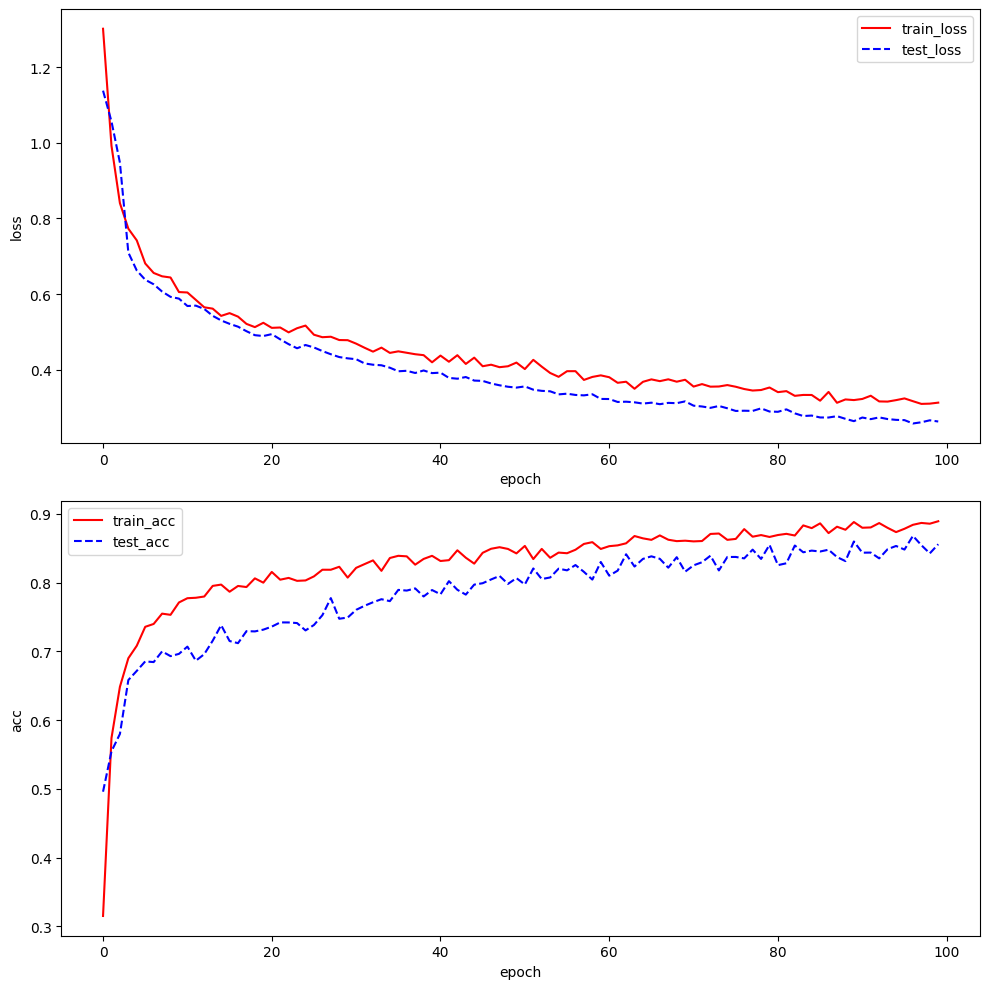

In [26]:
print(sum(p.numel() for p in efficient.parameters())/1e6, 'M parameters')
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = efficient.parameters(),lr=0.0001)
print("-----------Training Start---------------")
efficient_train_losses = []
efficient_test_losses = []
efficient_train_accuries = []
efficient_test_accuries = []
for epoch in range(EPOCHS):
    loss,accs,efficient = train_model(efficient,train_loader,optimizer,criterion)
    #scheduler.step()
    test_loss,t_accs = test_model(efficient,val_loader,criterion)
    efficient_train_losses.append(loss)
    efficient_test_losses.append(test_loss)
    efficient_train_accuries.append(accs)
    efficient_test_accuries.append(t_accs)
    if t_accs>.96 and t_accs<0.98:
        eff_best_acc = t_accs
        eff_best_model = copy.deepcopy(efficient)
    print(f'epoch:{epoch}|loss:{loss}|acc:{accs}|test_loss:{test_loss}|test_acc:{t_accs}')
print("-----------Training End---------------")

plot_graph(efficient_train_losses,efficient_train_accuries,efficient_test_losses,efficient_test_accuries)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       300
           1       0.79      0.88      0.83       306
           2       0.98      0.99      0.98       405
           3       0.91      0.95      0.93       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311

Specificities: [0.9812067260138477, 0.9303482587064676, 0.9889624724061811, 0.973293768545994]
0.9684528064181226
0.9070744256674365
0.9038901601830663
0.9032761146286397
0.9038901601830663


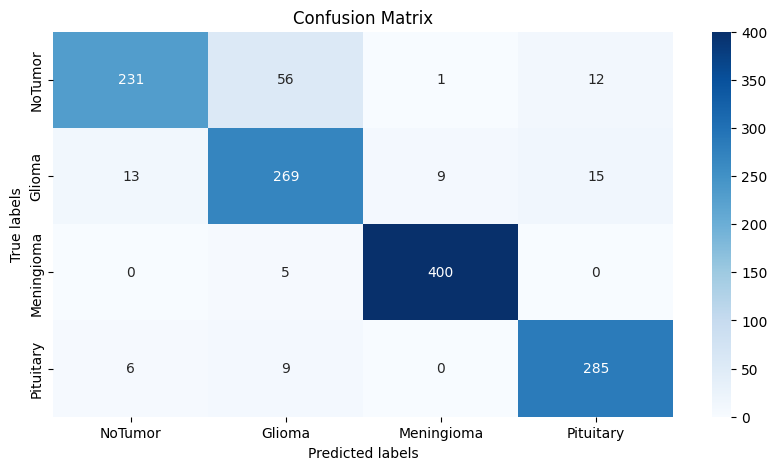

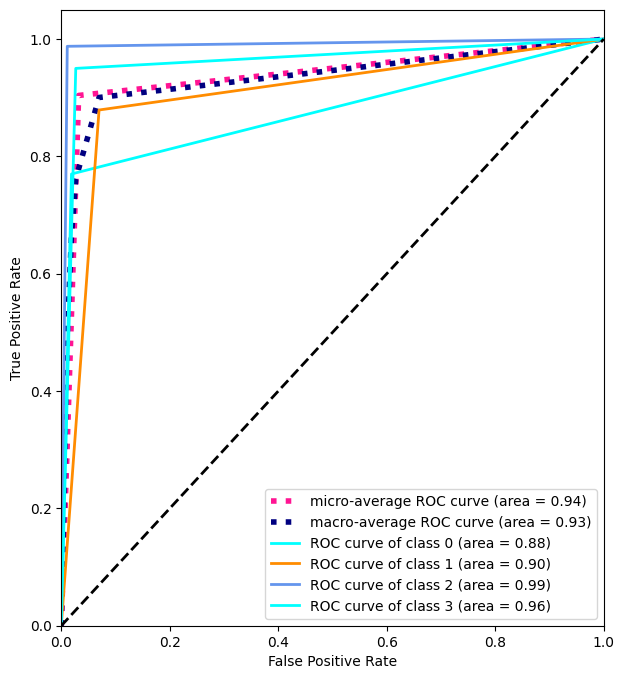

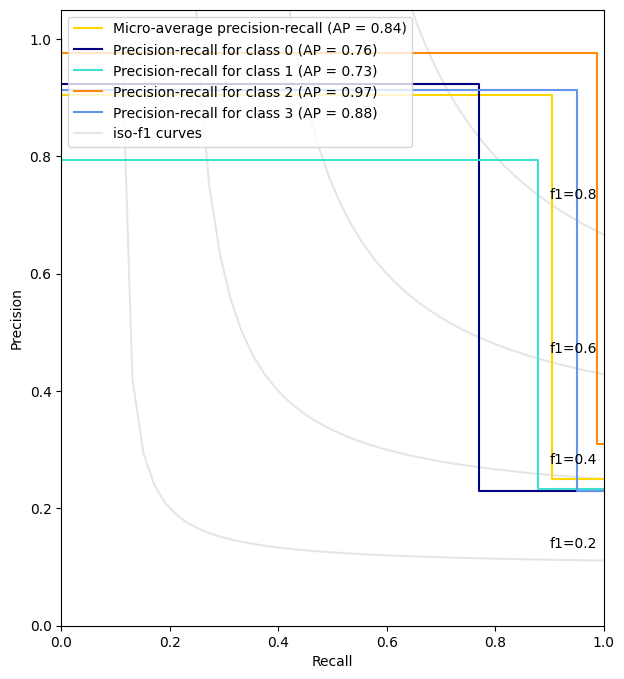

In [28]:
y_true = []
predict = []
for X,y in val_loader:
    y_pred = efficient(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/eff_conf.pdf',dpi=600)
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/eff_roc.pdf',dpi=600)
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    

    #plt.show()
    plt.savefig('/kaggle/working/eff_recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

### PDCNN

In [9]:
class MRI2D_Dataset3(Dataset):
    def __init__(self,PATH):
        images = []
        labels = []
        i = 0
        for dir,sub_dir,_ in os.walk(PATH):
            if dir!=PATH:
                for sub in sub_dir:
                    new_path = os.path.join(dir,sub)
                    if sub == 'pituitary':
                        i = 3
                    if sub == 'glioma':
                        i = 1
                    if sub == 'meningioma':
                        i = 2
                    if sub == 'notumor':
                        i = 0
                    for _,_,files in os.walk(new_path):
                        for file in files:
                            img_path = os.path.join(new_path,file)
                            img = cv2.imread(img_path)
                            img = self.data_preprocessing(img)
                            #img = img.reshape(img.shape[-1],img.shape[0],img.shape[1])
                            images.append(img)
                            labels.append(i)
        self.images = np.array(images)
        self.labels = np.array(labels).astype(np.int64)
    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        return img,label
    def __len__(self):
        return self.images.shape[0]
    def data_preprocessing(self,img):
        resized = cv2.resize(img,(128,128))
        normalized = (resized/255.0).astype(dtype=np.float32)
        return normalized

In [22]:
class LocalPath(nn.Module):
    def __init__(self):
        super(LocalPath,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=128,kernel_size=5,stride=2,padding=2)
        self.relu = nn.ReLU()
        self.norm1 = nn.LocalResponseNorm(5)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(in_channels=128,out_channels=96,kernel_size=5,stride=2,padding=2)
        self.conv3 = nn.Conv2d(in_channels=96,out_channels=96,kernel_size=5,stride=2,padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        return x

In [21]:
class GlobalPath(nn.Module):
    def __init__(self):
        super(GlobalPath,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=128,kernel_size=12,stride=2,padding=5)
        self.relu = nn.ReLU()
        self.norm1 = nn.LocalResponseNorm(5)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(in_channels=128,out_channels=96,kernel_size=12,stride=2,padding=5)
        self.conv3 = nn.Conv2d(in_channels=96,out_channels=96,kernel_size=12,stride=2,padding=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        return x

In [36]:
class PDCNN(nn.Module):
    def __init__(self):
        super(PDCNN,self).__init__()
        self.local_path = LocalPath()
        self.global_path = GlobalPath()
        self.norm = nn.BatchNorm2d(96)
        self.relu = nn.ReLU()
        
        self.classifier = nn.Sequential(
            nn.Linear(864,512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,4)
        )
        
    def forward(self,x):
        #x = x.unsqueeze(1)
        x = x.reshape(x.shape[0],x.shape[-1],x.shape[1],x.shape[2])
        lx = self.local_path(x)
        gx = self.global_path(x)
        
        x = lx + gx
        x = self.relu(self.norm(x))
        
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        
        return x

In [27]:
PATH = '/kaggle/input/brain-tumor-mri-dataset'
dataset = MRI2D_Dataset3(PATH)  
BATCH_SIZE = 32
TRAIN_SIZE = int(0.8*len(dataset))
TEST_SIZE = len(dataset)-TRAIN_SIZE
train_data,test_data = random_split(dataset,[TRAIN_SIZE,TEST_SIZE],generator=torch.manual_seed(42))
trainLoader = DataLoader(train_data, batch_size=32, shuffle=True)
testLoader = DataLoader(test_data, batch_size=32, shuffle=False)

In [40]:
pdcnn = PDCNN().to(device)

In [41]:
pdcnn_best_model = None
pdcnn_best_acc = 0

In [42]:
import copy

In [ ]:
print(sum(p.numel() for p in pdcnn.parameters())/1e6, 'M parameters')
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = pdcnn.parameters(),lr=0.0001)
print("-----------Training Start---------------")
pdcnn_train_losses = []
pdcnn_test_losses = []
pdcnn_train_accuries = []
pdcnn_test_accuries = []
for epoch in range(100):
    loss,accs,pdcnn = train_model(pdcnn,trainLoader,optimizer,criterion)
    #scheduler.step()
    test_loss,t_accs = test_model(pdcnn,testLoader,criterion)
    pdcnn_train_losses.append(loss)
    pdcnn_test_losses.append(test_loss)
    pdcnn_train_accuries.append(accs)
    pdcnn_test_accuries.append(t_accs)
    if t_accs>pdcnn_best_acc:
        pdcnn_best_acc = t_accs
        pdcnn_best_model = copy.deepcopy(pdcnn)
    print(f'epoch:{epoch}|loss:{loss}|acc:{accs}|test_loss:{test_loss}|test_acc:{t_accs}')
print("-----------Training End---------------")

plot_graph(pdcnn_train_losses,pdcnn_train_accuries,pdcnn_test_losses,pdcnn_test_accuries)

4.144836 M parameters
-----------Training Start---------------
epoch:0|loss:0.7859640717506409|acc:0.5906310677528381|test_loss:0.617938220500946|test_acc:0.7326619625091553
epoch:1|loss:0.4441837966442108|acc:0.813950777053833|test_loss:0.47556638717651367|test_acc:0.825022280216217
epoch:2|loss:0.2844288647174835|acc:0.8838033676147461|test_loss:0.3363521099090576|test_acc:0.8461341857910156
epoch:3|loss:0.18244266510009766|acc:0.9302501678466797|test_loss:0.21149438619613647|test_acc:0.9247750639915466
epoch:4|loss:0.09338777512311935|acc:0.9701392650604248|test_loss:0.1674807220697403|test_acc:0.9394298195838928
epoch:5|loss:0.051217734813690186|acc:0.9859529137611389|test_loss:0.16861766576766968|test_acc:0.9447162747383118
epoch:6|loss:0.042350683361291885|acc:0.9893034100532532|test_loss:0.20456193387508392|test_acc:0.9342023730278015
epoch:7|loss:0.018678875640034676|acc:0.9956203699111938|test_loss:0.22510495781898499|test_acc:0.9270761609077454
epoch:8|loss:0.0185760632157325

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       409
           1       0.92      0.92      0.92       325
           2       0.91      0.89      0.90       335
           3       0.97      0.98      0.97       336

    accuracy                           0.94      1405
   macro avg       0.94      0.94      0.94      1405
weighted avg       0.94      0.94      0.94      1405

Specificities: [0.9869477911646586, 0.975925925925926, 0.9719626168224299, 0.990645463049579]
0.9813704492406483
0.943549091765857
0.9437722419928826
0.9436368013464516
0.9437722419928826


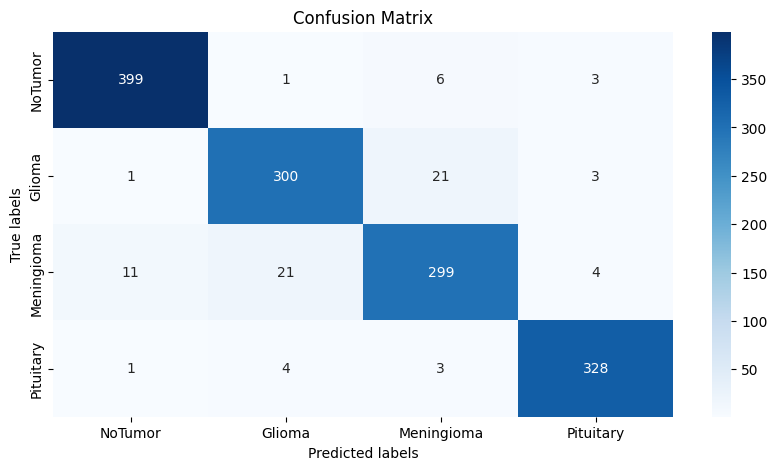

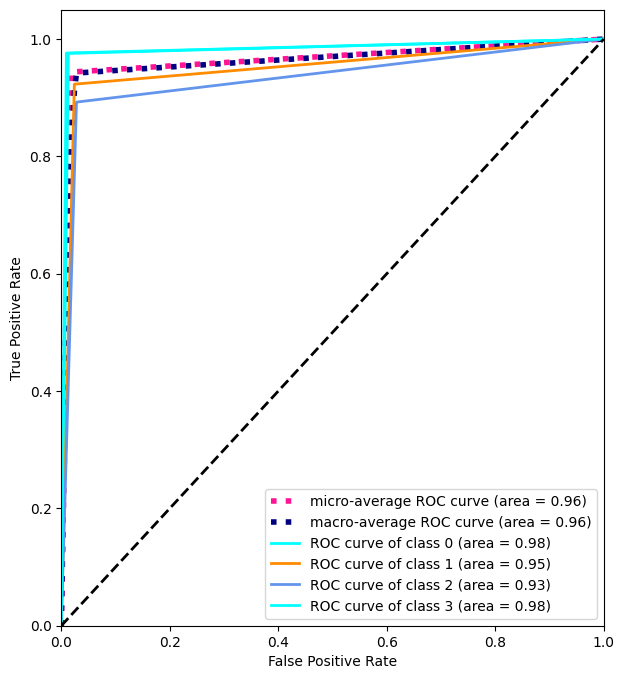

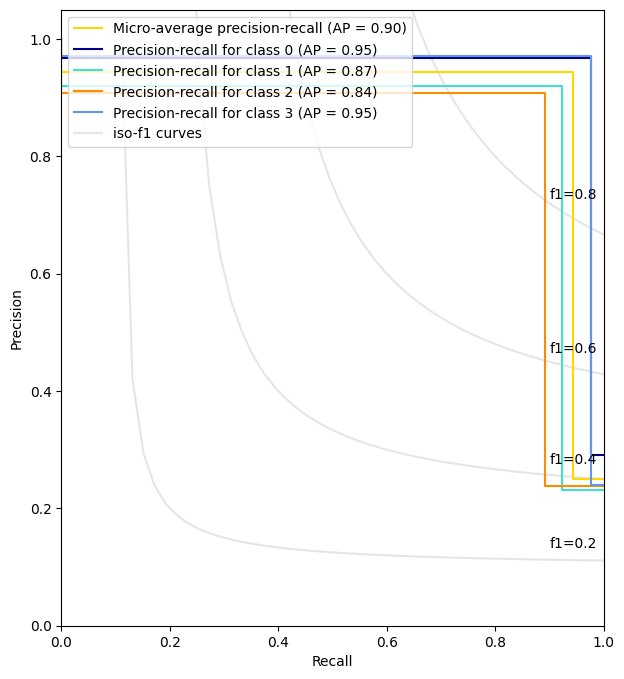

In [40]:
y_true = []
predict = []
for X,y in testLoader:
    y_pred = pdcnn_best_model(X.to(device))
    y_true.append(y.cpu().detach().numpy())
    predict.append(torch.argmax(y_pred,dim=1).cpu().detach().numpy())
predict = np.concatenate(predict, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
cm = confusion_matrix(y_true, predict)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/pdcnn_conf.pdf',dpi=600)
def plot_ROC(y_true, y_pred, classes=[0,1]): 
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_cl[i], pred_cl[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_all, pred_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,8), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('/kaggle/working/pdcnn_roc.pdf',dpi=600)
plot_ROC(y_true,predict,[0,1,2,3])
def plot_PrecRec(y_true, y_pred, classes=[0,1]): #2
    #y = label_binarize(y, classes=classes)
    n_classes = len(classes)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    true_cl, pred_cl = list(), list()
    for i in range(n_classes):
        true_cl.append(np.where(y_true != i, 0, 1).tolist())
        pred_cl.append(np.where(y_pred != i, 0, 1).tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_cl[i], pred_cl[i])
        average_precision[i] = average_precision_score(true_cl[i], pred_cl[i])

    true_all = list(itertools.chain.from_iterable(true_cl))
    pred_all = list(itertools.chain.from_iterable(pred_cl))

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        true_all, pred_all
    )
    average_precision["micro"] = average_precision_score(true_all, pred_all, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    

    #plt.show()
    plt.savefig('/kaggle/working/pdcnn_recall.pdf',dpi=600)
plot_PrecRec(y_true,predict,[0,1,2,3])
cr = classification_report(y_true,predict)
print(cr)
p = precision_score(y_true,predict,average='weighted')
r = recall_score(y_true,predict,average='weighted')
f = f1_score(y_true,predict,average='weighted')
# Calculate specificity for each class
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        # True negatives
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        # False positives
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)
    return specificities

specificities = calculate_specificity(cm)
print(f"Specificities: {specificities}")
s = np.array(specificities).mean()
print(s)
print(p)
print(r)
print(f)
print(accuracy_score(y_true,predict))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
ax[0].plot(test_losses, c='r', label='SCSAN')
ax[0].plot(vgg_test_losses, c='b',linestyle='--', label='VGG16')
ax[0].plot(resnet_test_losses,c='g',linestyle=':',label='ResNet50')
ax[0].plot(alex_test_losses,c='y',linestyle='-.',label='AlexNet')
ax[0].plot(efficient_test_losses,c='m',linestyle='-',marker='*',label='EfficientNet')
ax[0].plot(pdcnn_test_losses,c='c',linestyle='--',marker='+',label='PDCNN')
ax[0].set_xlabel('epoch')  
ax[0].set_ylabel('loss')   
ax[0].legend()

ax[1].plot(test_accuries, c='r', label='SCSAN')
ax[1].plot(vgg_test_accuries, c='b',linestyle='--', label='VGG16')
ax[1].plot(resnet_test_accuries,c='g',linestyle=':',label='ResNet50')
ax[1].plot(alex_test_accuries,c='y',linestyle='-.',label='AlexNet')
ax[1].plot(efficient_test_accuries,c='m',linestyle='-',marker='*',label='EfficientNet')
ax[1].plot(pdcnn_test_accuries,c='c',linestyle='--',marker='+',label='PDCNN')
ax[1].set_xlabel('epoch')  
ax[1].set_ylabel('acc')    
ax[1].legend()

fig.tight_layout()
plt.savefig('/kaggle/working/com.jpg',dpi=300)
plt.show()